In [ ]:
# 20220112 ok
import sys
sys.path.append("..")
import Config
import Func
import HG
import os
import time
import pandas as pd
import numpy as np

from pympler import asizeof

dataset='kosarak'

# =============================dataset path and file=============================

filename='kosarak.dat'
filepath=r"..\..\dataset\kosarak"
gr_file_name='kosarak_ground_truth.csv'
src_data=os.path.join(filepath,filename)
    # dataset
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth

# =============================Initialize=============================
heavy_size=8
light_size=16
size=400
b=1.08
topk=1024
if heavy_size*size<=topk:
    topk=heavy_size*size
Config.Set_default(heavy_size,light_size,size,b,topk)

# Generate a hash table
HG_list=[HG.HeavyGuardian() for _ in range(Config.size)]

# =============================Stream processing=============================
hg_start=time.time()
# stream processing
with open(src_data,'r') as file:
    while True:
        e=file.readline().strip('\n')
        if not e:
            print('EOF')
            break
        else:
            # Heavy part insert
            #item_count-=1
            item=HG.Node(str(e),1)
            HG_list=Func.InsertHG(item,HG_list)
hg_end=time.time()

# =============================Print and Plot result=============================
print("Execution time:{:8.3f} seconds.".format(hg_end-hg_start))
print("{} nodes, per-node= <{} heavy+ {} light>".format(len(HG_list),len(HG_list[0].heavy_part),len(HG_list[0].light_part)))

# =============================Top-k from result=============================
Top_dict=dict()
for i in range(len(HG_list)):
    for j in range(len(HG_list[i].heavy_part)):
        Top_dict[HG_list[i].heavy_part[j].ID]=HG_list[i].heavy_part[j].count
Top_dict=dict(sorted(Top_dict.items(), key=lambda item: item[1],reverse=True))

# Memory usage
sk0=asizeof.asizeof(Top_dict)
sk2=0
for item in HG_list:
    sk2+=asizeof.asizeof(item.light_part)
print("Total size {} kbytes, ".format((sk0+sk2)/1024))
print("Heavy part: {} kbytes".format(sk0/1024))
print("Light part: {} kbytes".format(sk2/1024))    

# Element-Precision
tp_set,precision=Func.Get_precision(gr_path,Top_dict,topk)
print("Precision: {:6.3f}".format(precision))

# Count ARE/AAE
startx=time.time()
# heavy part
gr=pd.read_csv(gr_path)
gr=gr[:topk]
result=pd.DataFrame(Top_dict.items(),columns=['Element','Count'])
result=result[:topk]
diff=gr.merge(result,how='inner',on='Element',suffixes=('_t', '_r'))
hare,haae=Func.Get_HH_ARE_AAE(diff)

# all
heavy_are,heavy_aae,all_are,all_aae=Func.Get_ARE_AAE(gr_path,HG_list,Top_dict)
endx=time.time()

print('heavy_are:{:6.3f},heavy_aae:{:6.3f}'.format(heavy_are,heavy_aae))
print('all_are:{:8.3f},all_aae:{:8.3f}'.format(all_are,all_aae))
print("Estimate time:{:8.3f} seconds.".format(endx-startx))

Func.Plot_topk_compare(gr_path,Top_dict,'Heavy Guardian')

# All element compare
ground_truth=Func.Get_ground_truth(gr_path)
My_result=dict()
for item in ground_truth:
    # item:ID of e
    My_result[item]=Func.HG_Query(item,HG_list)
Func.Plot_all_compare(ground_truth,My_result,'Heavy Guardian')

'''

# =============================result to csv=============================
path="..\\result\\HG\\"+dataset+"\\"+str(Config.size)+"_"+str(Config.heavy)

# Top_dict to csv
filename='HG_Top_'+str(Config.size*Config.heavy)+'_'+dataset+'.csv'
topdf=pd.DataFrame(Top_dict.items(),columns=['Element','Count'])
topdf.to_csv(os.path.join(path,filename),index=False)

# Sketch to csv
import numpy as np

light=np.empty(Config.light,dtype='int32')
for item in HG_list:
    #print(item.light_part,item.light_part.shape)
    light=np.vstack([light,item.light_part])
light=light[1:]

filename='HG_Sketch_'+str(Config.size)+'x'+str(Config.light)+'_'+dataset+'.csv'
pd.DataFrame(light).to_csv((os.path.join(path,filename)),index=False)

'''


In [ ]:
import pandas as pd
gr_df=pd.read_csv(gr_path)
result_df=pd.DataFrame(Top_dict.items(),columns=['Element','Count'])

gr_df=gr_df[:topk]
result_df=result_df[:topk]
tp_df=gr_df.merge(result_df,how='inner',on='Element',suffixes=('_t', '_r'))
tp_set=set(tp_df['Element'])
precision=len(tp_set)/topk
print(precision)

EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
EOF
Execution time: 394.134 seconds.
250 nodes, per-node= <8 heavy+ 16 light>
Find 0.742 of Heavy Hitters
Total size 306.890625 kbytes, 
Heavy part: 263.921875 kbytes
Light part: 42.96875 kbytes
hh_are: 0.005,hh_aae:67.810
Estimate time:   0.408 seconds.

For copy:
Execution time: 394.134 seconds.
250 nodes, per-node= <8 heavy+ 16 light>
Total size 306.890625 kbytes, 
Heavy part: 263.921875 kbytes
Light part: 42.96875 kbytes
Find 0.742 of Heavy Hitters
hh_are: 0.005,hh_aae:67.810
Estimate time:   0.408 seconds.


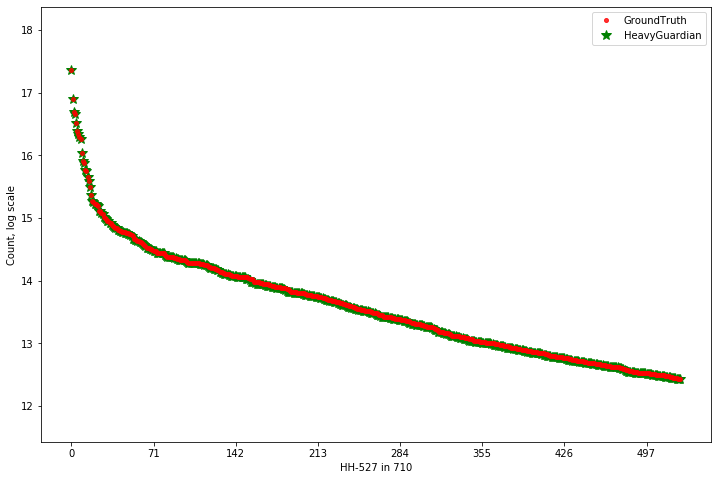

FileNotFoundError: [Errno 2] No such file or directory: '..\\result\\HG\\caida\\HH\\250_8\\HG_HH_710.csv'

In [6]:
# 20220112 ok

import sys
sys.path.append("..")
import Config
import Func
import HG
import os
import time
import pandas as pd

from pympler import asizeof

import re
total_count=0
heavy_ratio=1/5000
dataset='caida'

# =============================dataset path and file=============================

filepath=r"..\..\dataset\caida"
pattern='\w+.dat$'
r=re.compile(pattern)
filelist=list(filter(r.match,os.listdir(filepath)))    
    # dataset file list

gr_file_name='srcip\caida_ground_truth.csv'
    # ground truth of flows
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth path

# =============================Initialize=============================
heavy_size=8
light_size=16
size=250
b=1.08
topk=1024
if heavy_size*size<=topk:
    topk=heavy_size*size
Config.Set_default(heavy_size,light_size,size,b,topk)

# Generate a hash table
HG_list=[HG.HeavyGuardian() for _ in range(Config.size)]

# =============================Stream processing=============================
hg_start=time.time()
# stream processing
for datafile in filelist[:]:
    src_data=os.path.join(filepath,datafile)
    with open(src_data,'rb') as file:
         #以binary讀取，資料型態也為byte
        while True:
            e=file.read(13)
            if len(e)<13:
                print('EOF')
                break
            else:    
                # Heavy part insert
                #item_count-=1
                total_count+=1
                e=str(e[:4])
                item=HG.Node(str(e),1)
                HG_list=Func.InsertHG(item,HG_list)
hg_end=time.time()

# =============================Print and Plot result=============================
print("Execution time:{:8.3f} seconds.".format(hg_end-hg_start))
print("{} nodes, per-node= <{} heavy+ {} light>".format(len(HG_list),len(HG_list[0].heavy_part),len(HG_list[0].light_part)))

# =============================heavy hitter from result=============================
# get heavy part
Top_dict=dict()
for i in range(len(HG_list)):
    for j in range(len(HG_list[i].heavy_part)):
        Top_dict[HG_list[i].heavy_part[j].ID]=HG_list[i].heavy_part[j].count
Top_dict=dict(sorted(Top_dict.items(), key=lambda item: item[1],reverse=True))
    # sort by count

# =============================get HH    =============================
HH_df=pd.DataFrame(Top_dict.items(),columns=['Element','Count'])
HH_df=HH_df[HH_df['Count']>=int(total_count*heavy_ratio)]
HH_dict=dict(HH_df.values.tolist())
# =============================heavy hitter from ground truth=============================
import pandas as pd
df=pd.read_csv(gr_path)
temp=df[df['Count']>=int(total_count*heavy_ratio)]
# HH of ground truth
tp_df=temp.merge(HH_df,how='inner',on='Element',suffixes=('_t', '_r'))

# precison
print("Find {:.3f} of Heavy Hitters".format(len(tp_df['Element'])/len(temp['Element'])))

# Memory usage
sk0=asizeof.asizeof(Top_dict)
sk2=0
for item in HG_list:
    sk2+=asizeof.asizeof(item.light_part)
print("Total size {} kbytes, ".format((sk0+sk2)/1024))
print("Heavy part: {} kbytes".format(sk0/1024))
print("Light part: {} kbytes".format(sk2/1024))    

#=============================Count ARE/AAE=============================
startx=time.time()
hhare,hhaae=Func.Get_HH_ARE_AAE(tp_df)
#heavy_are,heavy_aae,all_are,all_aae=Func.Get_ARE_AAE(gr_path,HG_list,HH)
endx=time.time()

print('hh_are:{:6.3f},hh_aae:{:6.3f}'.format(hhare,hhaae))
#print('all_are:{:8.3f},all_aae:{:8.3f}'.format(all_are,all_aae))
print("Estimate time:{:8.3f} seconds.".format(endx-startx))

print("\nFor copy:")
print("Execution time:{:8.3f} seconds.".format(hg_end-hg_start))
print("{} nodes, per-node= <{} heavy+ {} light>".format(len(HG_list),len(HG_list[0].heavy_part),len(HG_list[0].light_part)))
print("Total size {} kbytes, ".format((sk0+sk2)/1024))
print("Heavy part: {} kbytes".format(sk0/1024))
print("Light part: {} kbytes".format(sk2/1024))   
print("Find {:.3f} of Heavy Hitters".format(len(tp_df['Element'])/len(temp['Element'])))
print('hh_are:{:6.3f},hh_aae:{:6.3f}'.format(hhare,hhaae))
#print('all_are:{:8.3f},all_aae:{:8.3f}'.format(all_are,all_aae))
print("Estimate time:{:8.3f} seconds.".format(endx-startx))

Func.Plot_hh_compare(temp,HH_dict,"HeavyGuardian")

# =============================result to csv=============================
path="..\\result\\HG\\"+dataset+"\\HH\\"+str(Config.size)+"_"+str(Config.heavy)
# Top_dict to csv
filename='HG_HH'+'_'+str(len(temp))+'.csv'
HH_df.to_csv(os.path.join(path,filename),index=False)
#topdf=pd.DataFrame(HH.items(),columns=['Element','Count'])
#os.path.join(path,filename)


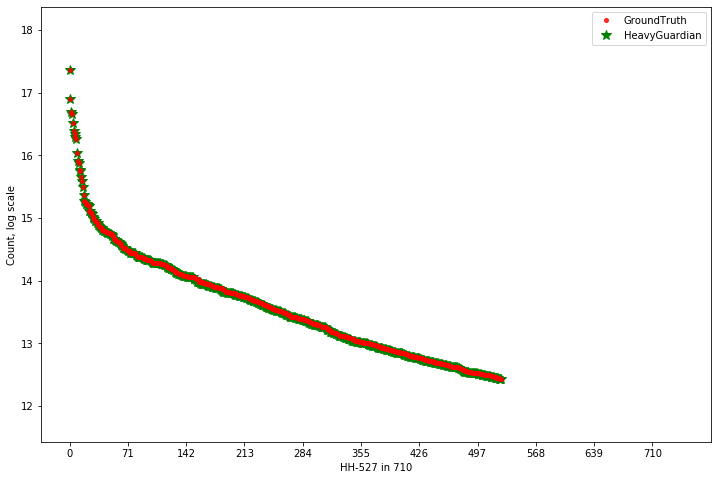

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def Plot_hhx_compare(ground_truth_df,result_dict,method):
    #
    gt_dict=dict(ground_truth_df.values)
    tp_set=set(gt_dict.keys()) & set(result_dict.keys())
    gt_dict=dict(sorted(gt_dict.items(), key=lambda item: item[1],reverse=True))
    
    x_axis=[i for i in range(len(tp_set))]
    y1=[result_dict[item] for item in tp_set]
    y1.sort(reverse=True)
    y_my=np.log2(y1)
    y2=[gt_dict[item] for item in tp_set]
    y2.sort(reverse=True)    
    y_gt=np.log2(y2)

    ymax=np.log2(max(max(gt_dict.values()),max(result_dict.values())))
    ymin=np.log2(min(min(gt_dict.values()),min(result_dict.values())))
    plt.figure(figsize=[12,8])
    #plt.xticks([j for j in range(0,int(len(x_axis)*1.1),int(len(x_axis)*1.1/10))])
    #plt.yticks([j for j in range(ymin,ymax)])
    #plt.xlim(0,int(len(tp_set)*1.02))
    plt.xticks([i for i in range(0,int(len(gt_dict)*1.1),int(len(gt_dict)/10))])
    plt.xlim(-int(len(gt_dict)/20),int(len(gt_dict)*1.1))
    plt.ylim(ymin-1,ymax+1)
    plt.xlabel('HH-{} in {}'.format(len(tp_set),len(gt_dict)))
    plt.ylabel('Count, log scale')
    my_line,=plt.plot(x_axis,y_my,'g*',label=method,alpha=1,markersize=10)
    gr_line,=plt.plot(x_axis,y_gt,'ro',label='GroundTruth',alpha=0.8,markersize=4)

    plt.legend(handles=[gr_line,my_line],loc='best')
    plt.show()
    
    
Plot_hhx_compare(temp,HH_dict,"HeavyGuardian")

EOF
Execution time:  17.269 seconds.
300 nodes, per-node= <8 heavy+ 16 light>
Find 0.953 of Heavy Hitters
Total size 315.953125 kbytes, 
Heavy part: 264.390625 kbytes
Light part: 51.5625 kbytes
hh_are: 0.006,hh_aae: 1.809
Estimate time:   0.109 seconds.

For copy:
Execution time:  17.269 seconds.
300 nodes, per-node= <8 heavy+ 16 light>
Total size 315.953125 kbytes, 
Heavy part: 264.390625 kbytes
Light part: 51.5625 kbytes
Find 0.953 of Heavy Hitters
hh_are: 0.006,hh_aae: 1.809
Estimate time:   0.109 seconds.


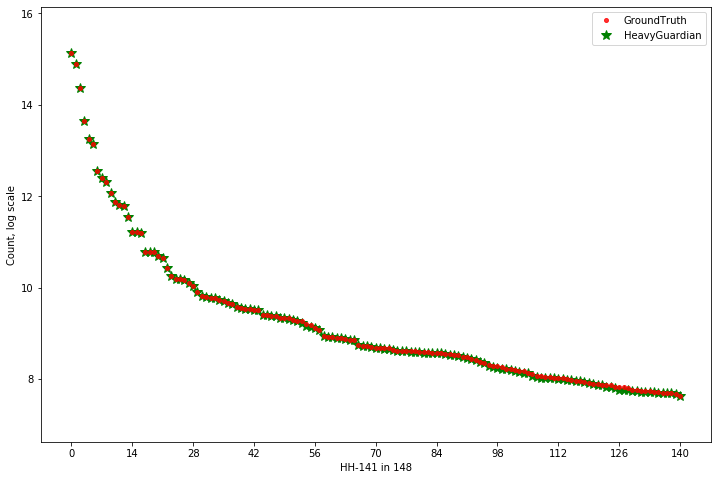

'\n# =============================result to csv=============================\npath="..\\result\\HG\\"+dataset+"\\HH\\"+str(Config.size)+"_"+str(Config.heavy)\n# Top_dict to csv\nfilename=\'HG_HH\'+\'_\'+str(len(temp))+\'.csv\'\nHH_df.to_csv(os.path.join(path,filename),index=False)\n#topdf=pd.DataFrame(HH.items(),columns=[\'Element\',\'Count\'])\n#os.path.join(path,filename)\n\n'

In [1]:
# 20220112 ok
# kosarak
import sys
sys.path.append("..")
import Config
import Func
import HG
import os
import time
import pandas as pd

from pympler import asizeof

total_count=0
heavy_ratio=1/5000
dataset='kosarak'

# =============================dataset path and file=============================

filename='kosarak.dat'
filepath=r"..\..\dataset\kosarak"
gr_file_name='kosarak_ground_truth.csv'
src_data=os.path.join(filepath,filename)
    # dataset
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth

# =============================Initialize=============================
heavy_size=8
light_size=16
size=300
b=1.08
topk=1024
if heavy_size*size<=topk:
    topk=heavy_size*size
Config.Set_default(heavy_size,light_size,size,b,topk)

# Generate a hash table
HG_list=[HG.HeavyGuardian() for _ in range(Config.size)]

# =============================Stream processing=============================
hg_start=time.time()
# stream processing
with open(src_data,'r') as file:
    while True:
        e=file.readline().strip('\n')
        if not e:
            print('EOF')
            break
        else:
            # Heavy part insert
            #item_count-=1
            total_count+=1
            item=HG.Node(str(e),1)
            HG_list=Func.InsertHG(item,HG_list)
hg_end=time.time()

# =============================Print and Plot result=============================
print("Execution time:{:8.3f} seconds.".format(hg_end-hg_start))
print("{} nodes, per-node= <{} heavy+ {} light>".format(len(HG_list),len(HG_list[0].heavy_part),len(HG_list[0].light_part)))

# =============================heavy hitter from result=============================
# get heavy part
Top_dict=dict()
for i in range(len(HG_list)):
    for j in range(len(HG_list[i].heavy_part)):
        Top_dict[HG_list[i].heavy_part[j].ID]=HG_list[i].heavy_part[j].count
Top_dict=dict(sorted(Top_dict.items(), key=lambda item: item[1],reverse=True))
    # sort by count

# =============================get HH    =============================
HH_df=pd.DataFrame(Top_dict.items(),columns=['Element','Count'])
HH_df=HH_df[HH_df['Count']>=int(total_count*heavy_ratio)]
HH_dict=dict(HH_df.values.tolist())
# =============================heavy hitter from ground truth=============================
import pandas as pd
df=pd.read_csv(gr_path)
temp=df[df['Count']>=int(total_count*heavy_ratio)]
# HH of ground truth
tp_df=temp.merge(HH_df,how='inner',on='Element',suffixes=('_t', '_r'))

# precison
print("Find {:.3f} of Heavy Hitters".format(len(tp_df['Element'])/len(temp['Element'])))

# Memory usage
sk0=asizeof.asizeof(Top_dict)
sk2=0
for item in HG_list:
    sk2+=asizeof.asizeof(item.light_part)
print("Total size {} kbytes, ".format((sk0+sk2)/1024))
print("Heavy part: {} kbytes".format(sk0/1024))
print("Light part: {} kbytes".format(sk2/1024))    

#=============================Count ARE/AAE=============================
startx=time.time()
hhare,hhaae=Func.Get_HH_ARE_AAE(tp_df)
#heavy_are,heavy_aae,all_are,all_aae=Func.Get_ARE_AAE(gr_path,HG_list,HH)
endx=time.time()

print('hh_are:{:6.3f},hh_aae:{:6.3f}'.format(hhare,hhaae))
#print('all_are:{:8.3f},all_aae:{:8.3f}'.format(all_are,all_aae))
print("Estimate time:{:8.3f} seconds.".format(endx-startx))

print("\nFor copy:")
print("Execution time:{:8.3f} seconds.".format(hg_end-hg_start))
print("{} nodes, per-node= <{} heavy+ {} light>".format(len(HG_list),len(HG_list[0].heavy_part),len(HG_list[0].light_part)))
print("Total size {} kbytes, ".format((sk0+sk2)/1024))
print("Heavy part: {} kbytes".format(sk0/1024))
print("Light part: {} kbytes".format(sk2/1024))   
print("Find {:.3f} of Heavy Hitters".format(len(tp_df['Element'])/len(temp['Element'])))
print('hh_are:{:6.3f},hh_aae:{:6.3f}'.format(hhare,hhaae))
#print('all_are:{:8.3f},all_aae:{:8.3f}'.format(all_are,all_aae))
print("Estimate time:{:8.3f} seconds.".format(endx-startx))

Func.Plot_hh_compare(temp,HH_dict,"HeavyGuardian")
'''
# =============================result to csv=============================
path="..\\result\\HG\\"+dataset+"\\HH\\"+str(Config.size)+"_"+str(Config.heavy)
# Top_dict to csv
filename='HG_HH'+'_'+str(len(temp))+'.csv'
HH_df.to_csv(os.path.join(path,filename),index=False)
#topdf=pd.DataFrame(HH.items(),columns=['Element','Count'])
#os.path.join(path,filename)

'''


In [2]:
len(HH_dict)

141